# MSP - projekt 2

_Note: pri kratších úsekoch kódu je odpoveď na otázku zadania v danej sekcií ako výstup kódu._

In [1]:
# Imports
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import chi2

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from copy import deepcopy

In [2]:
# Načítanie dát
file_path = 'Data_2024.xlsx'
sheet_name_ve = 'Data_věrohodnost'
sheet_name_re = 'Data_regrese'

Vdata = pd.read_excel(file_path, sheet_name=sheet_name_ve)
Rdata = pd.read_excel(file_path, sheet_name=sheet_name_re)

# Úprava stĺpcov
Vdata = Vdata.drop(columns='Unnamed: 2')
Vdata = Vdata.drop(columns='censored = 1 znamená přestal komunikovat; censored = 0 znamená změnil obor')

Vdata.columns = ['Censored', 'Time']
Rdata.columns = ['OSType', 'ActiveUsers', 'InteractingPct', 'ScrollingPct', 'Ping']


print(Vdata.head())
print(Rdata.head())


   Censored   Time
0         0  6.528
1         0  6.013
2         1  6.055
3         0  7.243
4         1  5.629
    OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping
0      iOS         4113          0.8283        0.1717    47
1      iOS         7549          0.3461        0.6539    46
2  Windows         8855          0.2178        0.7822    55
3  Android         8870          0.0794        0.9206    56
4    MacOS         9559          0.7282        0.2718    76


## Vierohodnosť


### 1. Weibullove rozdelenie pravdepodobnosti, logaritmická-vierohodnostná funkcia a jej parciálne derivácie

**Necenzurované pozorovania**

$f_{nec}(x,k,\lambda) =$ $\frac{k}{\lambda} (\frac{x}{\lambda})^{k-1}e^{-(\frac{x}{\lambda})^k}$, $L_{nec}(k,\lambda) =$ $\displaystyle \prod_{i=1}^{n}$ $\frac{k}{\lambda} (\frac{x_i}{\lambda})^{k-1}e^{-(\frac{x_i}{\lambda})^k}$

$l_{nec}(k,\lambda) =$ $n \ln(k) - n k \ln(\lambda) + (k-1)$ $\displaystyle \sum_{i=1}^{n} \ln(x_i)$ $- \frac{1}{\lambda^k}$ $\displaystyle \sum_{i=1}^{n} x_{i}^k$


**Cenzorované pozorovania**

$f_{cen}(x, k,\lambda) =$ $1 - F(x) = 1 - (1 - e^{-(\frac{x}{\lambda})^k}) = e^{-(\frac{x}{\lambda})^k}$, $L_{cen}(k,\lambda) =$ $\displaystyle \prod_{i=1}^{n}$ $e^{-(\frac{x_i}{\lambda})^k}$ 

$l_{cen}(k,\lambda) = -\frac{1}{\lambda^k}$ $\displaystyle \sum_{i=1}^{n} x_{i}^{k}$


**Parciálne derivácie**

$\frac{\partial l_{nec}}{\partial \lambda} = -\frac{nk}{\lambda} + \frac{k}{\lambda^{k+1}}$ $\displaystyle \sum_{i=1}^{n} x_{i}^k =$ $k(-\frac{n}{\lambda} + \lambda^{-k-1}$ $\displaystyle \sum_{i=1}^{n} x_{i}^k)$


$\frac{\partial l_{nec}}{\partial k} =\frac{n}{k} - n \ln(\lambda) +$ $\displaystyle \sum_{i=1}^{n} \ln(x_{i}) - [\displaystyle \lambda^k \sum_{i=1}^{n} x_{i}^k \ln(x_i) - \ln(\lambda) \lambda^k \sum_{i=1}^{n} x_{i}^k] / \lambda^{2k}$


$\frac{\partial l_{cen}}{\partial \lambda} = k \lambda^{-k-1} \displaystyle \sum_{i=1}^{n} x_{i}^k$


$\frac{\partial l_{cen}}{\partial k} = -[\displaystyle \lambda^k \sum_{i=1}^{n} x_{i}^k \ln(x_i) - \ln(\lambda) \lambda^k \sum_{i=1}^{n} x_{i}^k] / \lambda^{2k}$


**Pre zadané dáta dokopy**

$L(k,\lambda) = L_{nec}(k,\lambda) \times L_{cen}(k,\lambda)$

$l(k,\lambda) = l_{nec}(k,\lambda) + l_{cen}(k,\lambda)$

$\frac{\partial l}{\partial \lambda} = \frac{\partial l_{nec}}{\partial \lambda} + \frac{\partial l_{cen}}{\partial \lambda}$

$\frac{\partial l}{\partial k} = \frac{\partial l_{nec}}{\partial k} + \frac{\partial l_{cen}}{\partial k}$

### 2. Maximálne vierohodnostné odhady



In [3]:
# Logaritmická-vierohodnostná funkcia Weibulloveho rozdelenia
def weibull_log_likelihood(params, times, censored):
    k, lambd = params
    uncensored = 1 - censored
    
    f_x = (k / lambd) * (times / lambd)**(k - 1) * np.exp(-(times / lambd)**k)
    S_x = np.exp(-(times / lambd)**k)
    
    log_likelihood = np.sum(uncensored * np.log(f_x) + censored * np.log(S_x))
    return -log_likelihood


initial_guess_weibull = [1.0, 1.0]
result_weibull = minimize(weibull_log_likelihood, x0=initial_guess_weibull, args=(Vdata['Time'], Vdata['Censored']))

# Odhad k a lambda pre 
k, lambd = result_weibull.x
print(f'Maximálne vierohodnostné odhady: tvar (k) = {k:.5f}, mierka (lambda) = {lambd:.5f}')

Maximálne vierohodnostné odhady: tvar (k) = 6.17282, mierka (lambda) = 7.42946


### 3. Test vierohodnostným pomerom s exponenciálnym rozdelením

Vypočíta sa MLE pre parameter $\lambda$, keď $k = 1$ (viď. `exponential_log_likelihood`). Rovnako ako pri Weibulovom rozdelení pravdepodobnosti.

$H_0:$ Exponenciálne rozdelenie je postačujúcim modelom pre dané dáta.

$LR = 2 [l_{weibull}(k, \lambda) - l_{exp}(\lambda)]$

Doplnok kritického oboru je:

$\overline{W}_\alpha = \langle 0 ; \chi_{1-\alpha}^{2}(1) \rangle$


In [4]:
# Logaritmická-vierohodnostná funkcia Exponenciálneho rozdelenia
def exponential_log_likelihood(params, times, censored):
    lambd = params[0]
    uncensored = 1 - censored

    f_x = (1 / lambd) * np.exp(-times / lambd)
    S_x = np.exp(-times / lambd)

    log_likelihood = np.sum(uncensored * np.log(f_x) + censored * np.log(S_x))
    return -log_likelihood


initial_guess_exponential = [1.0]
result_exponential = minimize(exponential_log_likelihood, x0=initial_guess_exponential, args=(Vdata['Time'], Vdata['Censored']))
lambd_ex = result_exponential.x[0]


logL_weibull = -weibull_log_likelihood(result_weibull.x, Vdata['Time'], Vdata['Censored'])
logL_exponential = -exponential_log_likelihood(result_exponential.x, Vdata['Time'], Vdata['Censored'])

print(f'Maximálne vierohodnostný odhad lambdy pre exponenciálne rozdelenie: {lambd_ex:.5f}')


LR = 2 * (logL_weibull - logL_exponential)
critical_val = chi2.ppf(0.95, df=1) # alfa = 0.05

print(f'Likelihood Ratio (LR): {LR:.5f}')
print(f'Doplnok kritického intervalu: <0, {critical_val:.3f}>')


if 0 <= LR <= critical_val:
    print("Nezamietame H0: Exponenciálne rozdelenie je postačujúce.")
else:
    print("Zamietame H0: Exponenciálne rozdelenie nie je postačujúce.")

Maximálne vierohodnostný odhad lambdy pre exponenciálne rozdelenie: 9.05329
Likelihood Ratio (LR): 592.38982
Doplnok kritického intervalu: <0, 3.841>
Zamietame H0: Exponenciálne rozdelenie nie je postačujúce.


### 4. Bodové odhady pre strednú dobu zamestnania v obore

Stredná hodnota pre Weibullove rozdelenie pravdepodobnosti ([https://en.wikipedia.org/wiki/Exponential_distribution](https://en.wikipedia.org/wiki/Exponential_distribution)):

$E(X) = \lambda \Gamma (1 + \frac{1}{k})$

10% percentil sa dá vypočítať z distribučnej funkcie Weibulloveho rozdelenia:

$F(x,k,\lambda) = 1 - e^{-(\frac{x}{\lambda})^k}$

Percentil $x_p$ je hodnota, pri ktorej platí:

$F(x_p, k, \lambda) = p$

Po dosadení:

$1 - e^{-(\frac{x_p}{\lambda})^k} = p$

Po zlogaritmovaní a úprave:

$x_p = \lambda (-\ln(1 - p))^{\frac{1}{k}}$, teda

$x_{10\%} = \lambda (-\ln(1 - 0,1))^{\frac{1}{k}}$

In [5]:
# Stredná hodnota
mean_time = lambd * gamma(1 + 1 / k)

# 10% percentil
x_10 = lambd * (-np.log(0.9))**(1 / k)

print(f'Stredná doba zamestnania: {mean_time:.2f} rokov')
print(f'10% percentil: {x_10:.2f} rokov')

Stredná doba zamestnania: 6.90 rokov
10% percentil: 5.16 rokov


## Regresia

1. Nájdenie vhodného regresného modelu.
    - Úvaha nad dátami a odstránenie zjavne leneárne závislých prediktorov.
    - Štandardizácia modelu a odstránenie štatisticky nevýznamných prediktorov na základe p-hodnoty.
    - Odstránenie extrémne odľahlých hodnôt
    - Multikolinearity
    - Finálna kontrola
2. Najproblematickejšie hodnoty
3. Odozva užívateľa Windows
4. Vhodnosť výsledného modelu

### 1. Vhodný regresný model

_Note: Priebežne v kóde sú komentáre, ktoré odkazujú všetky zmienené body._

0. Vytvorenie plného modelu. Pre tento účel som si vytvoril funkciu `generate_full_formula()`, ktorá vracia formulu v jazyku **R**, podľa ktorej sa vytvorí neskôr model. Čo sa týka kategoriálneho prediktoru `OSType`, tak keďže je počet jednotlivých kategórií približne rovnaký a považujem ich za celkom rovnocenné tak nebudem špecificky vyberať referenčnú kategóriu a nechám to na lexikografickom poradí.

1. **Úvaha:** Pri prvom pohľada na dáta možno pozorovať, že prediktory `ScrollingPct` a `InteractingPct` sú na sebe úplne závislé, pretože sa sčítajú do 1.
Online užívatelia sú rozdelení na dve skupiny tí, ktorí interagujú s obsahom a tí čo len scrollujú. Každopádne podľa jedného z týchto prediktorov je možné určiť ten druhý. To znamená, že nám stačí jeden z nich. Ja som sa rozhodol odstrániť prediktor `ScrollingPct`, jeho druhú mocninu a interakcie druhého rádu so všetkými ostatnými prediktormi, keďže všetky tieto hodnoty (len opačné) zahŕňa prediktor `InteractingPct`, jeho druhá mocninu a interackie druhého rádu. Túto závislosť možno pekne vidieť v tabuľke korelácií `ScrollingPct` a `InteractingPct`.

2. **Odstránenie prediktorov, ktoré nepridávajú hodnotu:** Najskôr som sa rozhodol štandardizovať všetky prediktory a z nich odstrániť tie prediktory, ktoré sú štatisticky nevýznamné na základe ich p-hodnoty. Na tento účel som vytvoril funkciu `backward_elimination()`.

3. **Odstránenie odľahlých hodnôt:** Po analýze vykonanej pomocou diagnostických grafov, leverage, štandardizovaných reziduí a Cookovej vzdialenosti som našiel dva veľmi odľahlé body, ktoré mi prídu až moc podozrivé na to aby sa vyskytli pri 500 pozorovaniach len dva. Tieto body je veľmi pekne vidno v diagnostických grafoch, ale aj v tabuľke štandardizovaných reziduí alebo pri leverage.

4. Kontrola: v takto spracovanom modely sú všetky prediktory štatisticky významé, avšak podľa VIFu existuje multikolinearita medzi `ActiveUsers` a `I(ActiveUsers**2)`. `I(ActiveUsers**2)` má záporný koeficient (aj keď veľmi malý), čo mi nedáva zmysel aby ping od určitej hodnoty aktívnych užívateľov klesal, naopak by som očakával, že bude rásť. Preto som sa rozhodol odstrániť prediktor `I(ActiveUsers**2)`. 

5. Finálna kontrola: Teraz sú už všetky prediktory štatisticky významné a podľa dát z VIFu a vzájomnej korelácie by som nemazal žiaden ďalší prediktor.

Čo sa týka finálneho neštandardizovaného modelu, tak niektoré prediktory pre `OSType` sa síce javia ako štatisticky nevýznamné. To však bude zrejem tým, že nehľadiac na operačný systém ping bude podobný (aspoň medzi niektorými kategóriami) v tomto prípade by som však zachoval všekty kategórie, pretože ich budeme potrebovať ak chceme porovnávať jednotlivé operačné systémy medzi sebou. Vynechať jednu kategóriu a zachovať inú mi v tomto prípade nedáva zmysel ak chceme sledovať rozdiely medzi kategóriami OS.


**Rovnica finálneho modelu**

$Ping = 9,9548 + 6.7916 * Windows - 1,9029 * MacOS - 1,9057 * iOS + 0,0055 * ActiveUsers -$ $0,0008 * iOS * ActiveUsers - 0,0006 * Windows * ActiveUsers + 0,0020 * MacOS * ActiveUsers +$ $36,7221 * InteractingPct - 0,0035 * ActiveUsers * InteractingPct$

MacOS, iOS, a Windows sú binárne premenné (1 ak ide o daný OS, inak 0) podľa kategoriálneho prediktoru `OSType`, referenčná kategória je Android.


**Predpoklady lineárnej regresie a základné diagnostiky**

Model dosahuje dobrú vysvetľovaciu schopnosť s hodnotami $R^2 = 0,842$ a Adjusted $R^2 = 0,839$, čo naznačuje, že približne $84\%$ variability závislej premennej je vysvetlených modelom.

1. **Multikolinearita:** Hodnoty VIF a korelácie sú v prijateľnom rozsahu, čo znamená, že multikolinearita medzi prediktormi nie je problémom.

2. **Normalita rezíduí:** Testy Jarque-Bera ($0,104$) a Omnibus ($0.195$) naznačujú, že rezíduá sa riadia normálnym rozdelením.

3. **Autokorelácia:** Hodnota Durbin-Watson ($1,913$) je blízka 2, čo znamená absenciu autokorelácie rezíduí.



In [6]:
# Trieda pre prácu s formulou
class Formula:
    def __init__(self, response):
        self.response:str = response
        self.formula:set = set()

    def __str__(self):
        res = (self.response + ' ~ ')
        for i, term in enumerate(self.formula):
            res += term
            if i != len(self.formula) - 1:
                res += ' + '
            if (i+1) % 3 == 0:
                res += '\n'
        return res
    
    def Get(self) -> str:
        res = (self.response + ' ~ ')
        for i, term in enumerate(self.formula):
            res += term
            if i != len(self.formula) - 1:
                res += ' + '
        return res
    
    def Copy(self):
        return deepcopy(self)

    def Add(self, formula:str):
        self.formula.add(formula)

    def Remove(self, formula:str):
        self.formula.remove(formula)
        


# Funkcia pre vygenerovanie plnej formule
def generate_full_formula(data, response, predictors, category_vars) -> Formula:
    formula = Formula(response)
    dummies_names = []
    for var in predictors:
        if var in category_vars:
            dummies = pd.get_dummies(data[var], prefix=var, drop_first=True)
            dummies_names += dummies.columns.to_list()
            for dummy in dummies_names:
                formula.Add(dummy)
        else:
            formula.Add(var)
            formula.Add(f'I({var}**2)')

    all_ = dummies_names + predictors
    
    # Interakcie druhého rádu
    for i, var1 in enumerate(all_):
        for var2 in all_[i + 1:]:
            if (var1 in dummies_names and var2 in dummies_names) or (var1 in category_vars or var2 in category_vars):
                continue
            formula.Add(f'{var1}:{var2}')
    
    return formula


# ----------------------------------------------------------#
# "Plný" regresný model pre dané dáta

predictors = ['ActiveUsers', 'InteractingPct', 'ScrollingPct', 'OSType']
category_vars = ['OSType']
formula:Formula = generate_full_formula(Rdata, response="Ping", predictors=predictors, category_vars=category_vars)

# Vypíš formulu
print(formula)
print('\n\n')

# Úprava stĺpcov pre kategoriálne dáta
dummies = dummy_ostype = pd.get_dummies(Rdata['OSType'], prefix='OSType', drop_first=True)
Rdata = pd.concat([Rdata, dummies], axis=1)

# Vytvorenie plného modelu
model = smf.ols(formula=formula.Get(), data=Rdata)
result = model.fit()
print(result.summary())
print('\n\n')


# Počty jednotlivých kategórií
# Keďže je počet jednotlivých kategórií približne rovnaký a považujem ich za celkom rovnocenné tak
# nebudem špecificky vyberať referenčnú kategóriu a nechám to na lexikografickom poradí.
print(Rdata['OSType'].value_counts())


Ping ~ I(ActiveUsers**2) + OSType_MacOS:ActiveUsers + OSType_Windows:ActiveUsers + 
ActiveUsers + ActiveUsers:ScrollingPct + ScrollingPct + 
I(ScrollingPct**2) + InteractingPct:ScrollingPct + OSType_Windows:InteractingPct + 
InteractingPct + ActiveUsers:InteractingPct + OSType_Windows:ScrollingPct + 
OSType_MacOS:ScrollingPct + OSType_MacOS + OSType_iOS:ActiveUsers + 
OSType_Windows + OSType_iOS + OSType_iOS:InteractingPct + 
OSType_iOS:ScrollingPct + I(InteractingPct**2) + OSType_MacOS:InteractingPct




                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        12:54:46   Log-Likelihood:                -1598.4
No. Observation

In [7]:
# ----------------------------------------------------------#
# 1. Odstránenie závislosti medzi InteractingPct a ScrollingPct

X = pd.DataFrame(model.exog, columns=model.exog_names)

# VIF (kód z democvičenia)
# VIF toho moc neukázal, ale korelácia áno...
#vif = pd.Series([variance_inflation_factor(X.values, i)
#                 for i in range(X.shape[1])],
#                 index=X.columns)

#vif_df = vif.to_frame()
#vif_df.columns = ['VIF']
#print(vif_df)
#print('\n\n\n')

# Korelácia
# Z tejto korelácie je veľmi dobre vidieť, že InteractingPct a ScrollingPct sú na sebe
# úplne závislé a stačí používať len jeden z nich.
print(X.corr().loc[['InteractingPct', 'ScrollingPct', 'InteractingPct:ScrollingPct',
                'ActiveUsers:InteractingPct', 'ActiveUsers:ScrollingPct',
                'OSType_MacOS[T.True]:InteractingPct', 'OSType_MacOS[T.True]:ScrollingPct',
                'OSType_Windows[T.True]:InteractingPct', 'OSType_Windows[T.True]:ScrollingPct',
                'OSType_iOS[T.True]:InteractingPct', 'OSType_iOS[T.True]:ScrollingPct'],
                ['InteractingPct', 'ScrollingPct']])

print('\n\n')

# Odstránenie ScrollingPct jeho druhje mocniny a interakcie druhého rádu
to_remove = ['ScrollingPct', 'I(ScrollingPct**2)', 'ActiveUsers:ScrollingPct', 'OSType_MacOS:ScrollingPct', 
             'OSType_Windows:ScrollingPct', 'OSType_iOS:ScrollingPct', 'InteractingPct:ScrollingPct']
better_formula = formula.Copy()
for term_to_remove in to_remove:
    term_to_remove = term_to_remove.replace('[T.True]', '')
    term_to_remove = term_to_remove.replace(' ', '')
    better_formula.Remove(term_to_remove)

print(better_formula)

                                       InteractingPct  ScrollingPct
InteractingPct                               1.000000     -1.000000
ScrollingPct                                -1.000000      1.000000
InteractingPct:ScrollingPct                  0.022835     -0.022835
ActiveUsers:InteractingPct                   0.752979     -0.752979
ActiveUsers:ScrollingPct                    -0.711749      0.711749
OSType_MacOS[T.True]:InteractingPct          0.388633     -0.388633
OSType_MacOS[T.True]:ScrollingPct           -0.275403      0.275403
OSType_Windows[T.True]:InteractingPct        0.248636     -0.248636
OSType_Windows[T.True]:ScrollingPct         -0.262914      0.262914
OSType_iOS[T.True]:InteractingPct            0.244987     -0.244987
OSType_iOS[T.True]:ScrollingPct             -0.314208      0.314208



Ping ~ I(ActiveUsers**2) + OSType_MacOS:ActiveUsers + OSType_Windows:ActiveUsers + 
ActiveUsers + OSType_Windows:InteractingPct + InteractingPct + 
ActiveUsers:InteractingPct + OSTy

In [8]:
# ----------------------------------------------------------#
# 2. Štandardizovaný model

def standardize(data:pd.DataFrame, predictor:str):
    return(data[predictor]-((data[predictor].max()+data[predictor].min())/2))/(data[predictor].max()-data[predictor].min())*2


no_cat_predictors = ['ActiveUsers', 'InteractingPct', 'ScrollingPct']
RdataSS = Rdata.copy()
for predictor in no_cat_predictors:
    RdataSS[predictor] = standardize(RdataSS, predictor)


modelSS = smf.ols(formula=better_formula.Get(), data=RdataSS)
resultSS = modelSS.fit()
print(resultSS.summary())

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          5.18e-186
Time:                        12:54:46   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [9]:

# Automatizovaný algoritmus pre spätnú elimináciu
def backward_elimination(data:pd.DataFrame, initial_formula:Formula, alpha:float=0.05):
    # Začneme s plným modelom
    formula:Formula = initial_formula.Copy()
    while True:
        model = smf.ols(formula=formula.Get(), data=data)
        result = model.fit()
        
        pvalues = result.pvalues
        
        max_pval = pvalues.drop('Intercept').max()
        if max_pval > alpha:
            term_to_remove = pvalues.idxmax()
            term_to_remove = term_to_remove.replace('[T.True]', '')
            term_to_remove = term_to_remove.replace(' ', '')
            print(f'Odstránené: {term_to_remove}, p-hodnota: {max_pval}')
            formula.Remove(term_to_remove)
        else:
            break
    
    return model, formula


# ----------------------------------------------------------#
# 2. Odstránenie nevýznamných prediktorov podľa p-hodnoty

# Spustenie spätnej eliminácie
best_model, best_formula = backward_elimination(RdataSS, initial_formula=better_formula)
best_result = best_model.fit()

print('\n\n')
print(best_result.summary())

Odstránené: OSType_iOS:InteractingPct, p-hodnota: 0.9207665221385899
Odstránené: OSType_Windows:InteractingPct, p-hodnota: 0.9023977373454158
Odstránené: OSType_MacOS:InteractingPct, p-hodnota: 0.7602205074876843
Odstránené: I(InteractingPct**2), p-hodnota: 0.27753223057954146



                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.69e-190
Time:                        12:54:46   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covarian

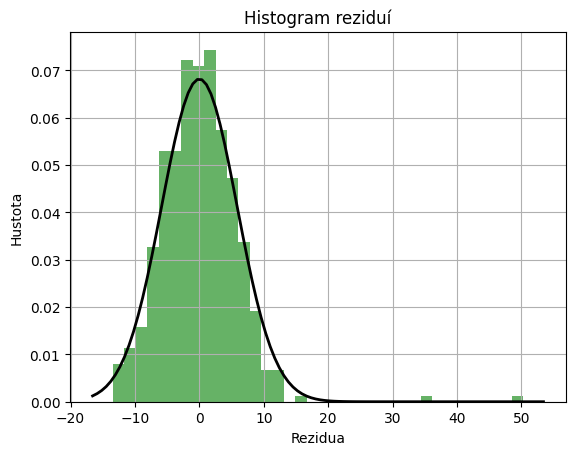

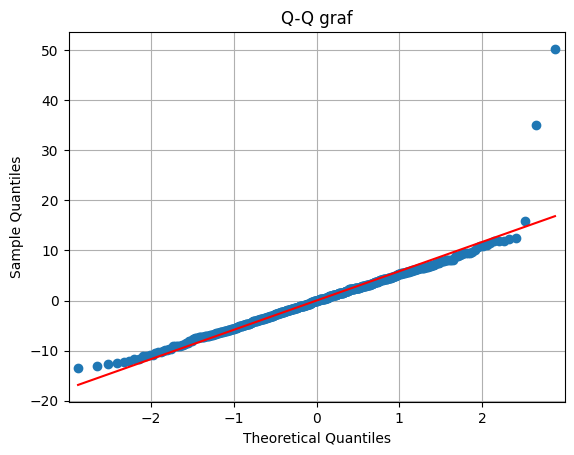

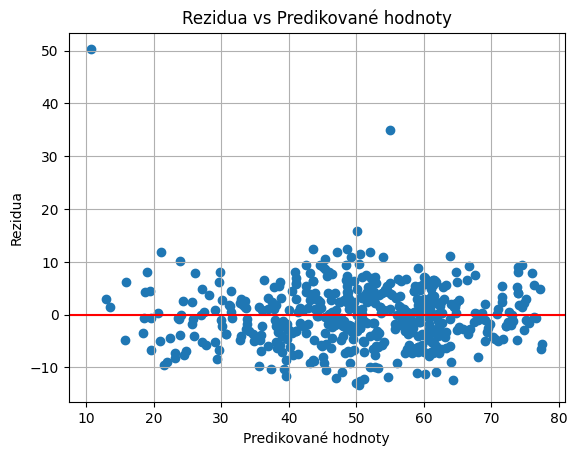

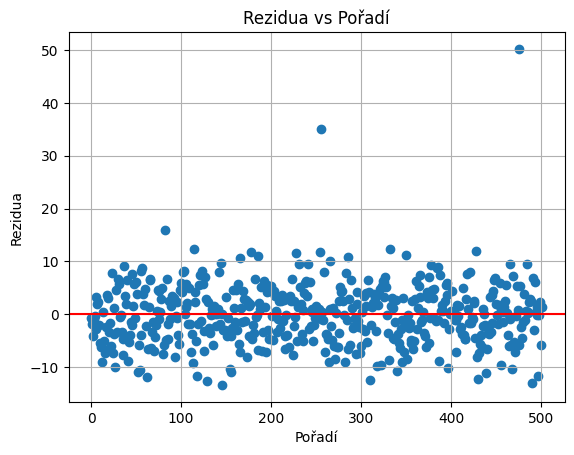

     Leverage  Standardized Residuals  Studentized Residuals  \
62   0.012590               -2.036977              -2.043554   
82   0.010646                2.699228               2.716710   
114  0.012955                2.111260               2.118748   
129  0.014222               -2.141213              -2.149089   
145  0.023780               -2.292470              -2.302490   
178  0.047086                2.054883               2.061673   
254  0.011482                2.011917               2.018204   
255  0.009986                5.945469               6.165493   
310  0.016649               -2.111115              -2.118601   
332  0.030075                2.124928               2.132592   
428  0.028086                2.048785               2.055502   
430  0.017414               -2.080739              -2.087844   
476  0.074941                8.830417               9.618155   
490  0.026903               -2.230330              -2.239431   

     Studentized Residuals p-value  Coo

In [10]:
# ---------------------------------------------------------- #
# 3. Odstránenie odľahlých hodnôt

##### Diagnostické grafy (kód z democvičenia) #####

plt.hist(best_result.resid, bins='auto', density=True, alpha=0.6, color='g')

# Gaussovy krivky
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(best_result.resid), np.std(best_result.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.grid(True)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")
plt.show()

# Q-Q graf
qqplot(best_result.resid, line='s')
plt.title('Q-Q graf')
plt.grid(True)
plt.show()

# res vs fit
plt.scatter(best_result.fittedvalues, best_result.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# res vs order
plt.scatter(range(len(best_result.resid)), best_result.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Pořadí")
plt.xlabel("Pořadí")
plt.ylabel("Rezidua")

plt.show()


##### Leverage, štandardizované rezidua, Cookova vzdialenosť (kód z democvičenia) #####

influence = best_result.get_influence()
# Leverage
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) ako n-tica polí [n x 2]
cooks_d = influence.cooks_distance
# Standardizované rezidua
standardized_residuals = influence.resid_studentized_internal
# Študentizované rezidua
studentized_residuals = influence.resid_studentized_external
# Výpočet p-hodnôt pre študentizované rezidua
studentized_residuals_pvalues = 2 * (1 - stats.t.cdf(np.abs(studentized_residuals), df=Rdata.shape[0]-len(best_result.params)))


outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Studentized Residuals p-value': studentized_residuals_pvalues,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=Rdata.index)
# Výber "zaujímavých" hodnôt (kód z democvičenia)
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(best_result.params)/Rdata.shape[0]) | 
                              (np.abs(outl_stats_df['Standardized Residuals']) > 2) | 
                              (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]
print(outl_stats_df)


                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.28e-215
Time:                        12:54:46   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

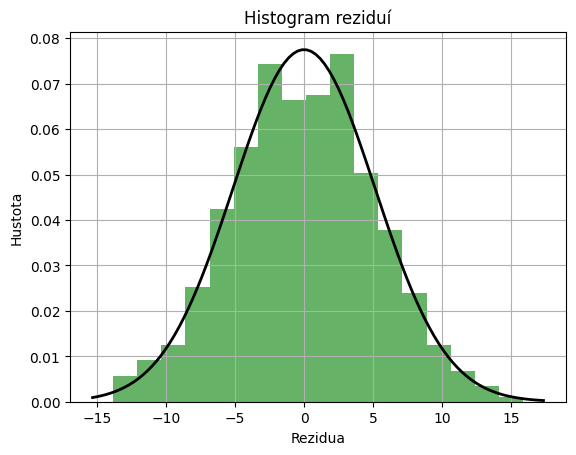

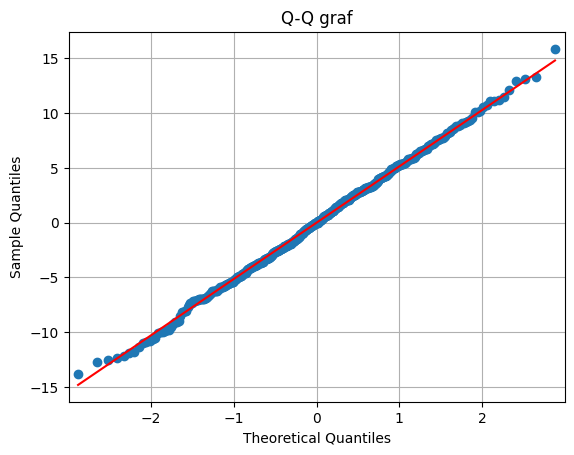

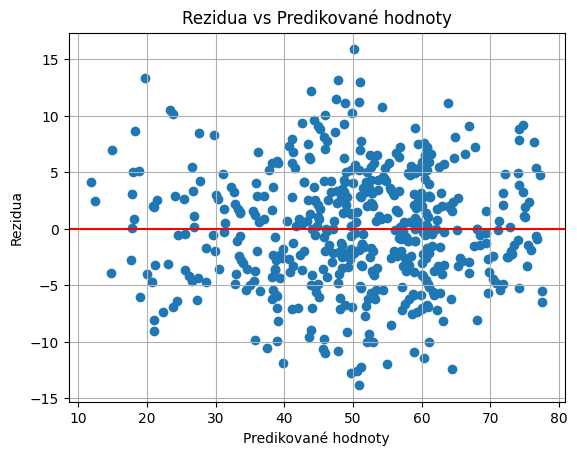

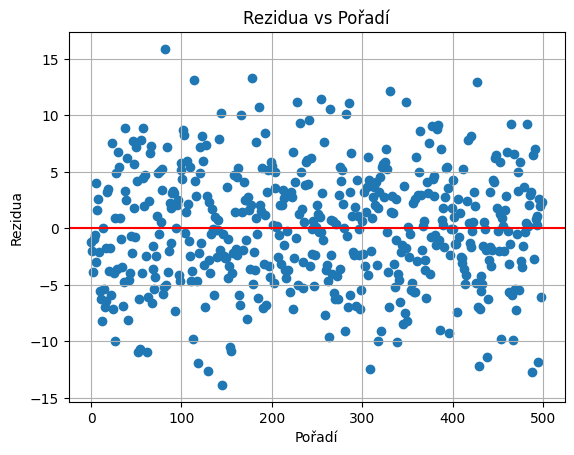

     Leverage  Standardized Residuals  Studentized Residuals  \
52   0.018193               -2.120187              -2.127821   
54   0.026599               -2.074386              -2.081442   
62   0.012941               -2.120597              -2.128236   
82   0.010775                3.066469               3.093217   
114  0.013115                2.538616               2.552897   
118  0.011757               -2.308893              -2.319207   
129  0.014368               -2.433998              -2.446373   
144  0.039306                2.000763               2.006948   
145  0.023860               -2.693010              -2.710429   
154  0.016115               -2.036268              -2.042864   
155  0.013696               -2.095390              -2.102707   
178  0.047766                2.619997               2.635883   
186  0.014604                2.084850               2.092036   
228  0.011648                2.162591               2.170785   
254  0.011564                2.216516   

In [11]:
# Neštandardizovaný model, bez odľahlých hodnôt [255 a 476]
Rdata_filtered = Rdata.drop([255, 476], inplace=False)
best_model_filtered = smf.ols(formula=best_formula.Get(), data=Rdata_filtered)
best_result_filtered = best_model_filtered.fit()
print(best_result_filtered.summary())


# ---------------------------------------------------------- #
# 3. Po odstránení odľahlých hodnôt

##### Diagnostické grafy (kód z democvičenia) #####

plt.hist(best_result_filtered.resid, bins='auto', density=True, alpha=0.6, color='g')

# Gaussovy krivky
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(best_result_filtered.resid), np.std(best_result_filtered.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.grid(True)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")
plt.show()

# Q-Q graf
qqplot(best_result_filtered.resid, line='s')
plt.title('Q-Q graf')
plt.grid(True)
plt.show()

# res vs fit
plt.scatter(best_result_filtered.fittedvalues, best_result_filtered.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# res vs order
plt.scatter(range(len(best_result_filtered.resid)), best_result_filtered.resid)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(True)
plt.title("Rezidua vs Pořadí")
plt.xlabel("Pořadí")
plt.ylabel("Rezidua")

plt.show()


##### Leverage, štandardizované rezidua, Cookova vzdialenosť (kód z democvičenia) #####

influence = best_result_filtered.get_influence()
# Leverage
leverage = influence.hat_matrix_diag
# Cookovy D hodnoty (a p-hodnoty) ako n-tica polí [n x 2]
cooks_d = influence.cooks_distance
# Štandardizované rezidua
standardized_residuals = influence.resid_studentized_internal
# Študentizované rezidua
studentized_residuals = influence.resid_studentized_external
# Výpočet p-hodnôt pre študentizované rezidua
studentized_residuals_pvalues = 2 * (1 - stats.t.cdf(np.abs(studentized_residuals), df=Rdata.shape[0]-len(best_result_filtered.params)))


outl_stats_df = pd.DataFrame({
    'Leverage': leverage,
    'Standardized Residuals': standardized_residuals,
    'Studentized Residuals': studentized_residuals,
    'Studentized Residuals p-value': studentized_residuals_pvalues,
    'Cook\'s Distance': cooks_d[0],
    'Cook\'s Distance_p-value': cooks_d[1]
}, index=Rdata_filtered.index)
# Výber "zaujímavých" hodnôt
outl_stats_df = outl_stats_df[(outl_stats_df['Leverage'] > 3*len(best_result_filtered.params)/Rdata.shape[0]) | 
                              (np.abs(outl_stats_df['Standardized Residuals']) > 2) | 
                              (outl_stats_df['Cook\'s Distance_p-value'] < 0.05)]
print(outl_stats_df)


In [12]:
# 4. Kontrola multikolinearity

X = pd.DataFrame(best_model_filtered.exog, columns=best_model_filtered.exog_names)

# VIF (z democvičenia)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)

vif_df = vif.to_frame()
vif_df.columns = ['VIF']
print(vif_df)
print('\n\n\n')

# Korelácia
print(X.corr()[['ActiveUsers', 'I(ActiveUsers ** 2)']])

                                          VIF
Intercept                           61.935626
OSType_MacOS[T.True]                10.328997
OSType_Windows[T.True]               9.758714
OSType_iOS[T.True]                   9.248966
ActiveUsers                         30.613252
OSType_Windows[T.True]:ActiveUsers  10.038729
OSType_iOS[T.True]:ActiveUsers       8.997457
OSType_MacOS[T.True]:ActiveUsers    10.528764
I(ActiveUsers ** 2)                 22.999789
InteractingPct                       5.712444
ActiveUsers:InteractingPct           8.720958




                                    ActiveUsers  I(ActiveUsers ** 2)
Intercept                                   NaN                  NaN
OSType_MacOS[T.True]                   0.006710            -0.000737
OSType_Windows[T.True]                 0.000596             0.008306
OSType_iOS[T.True]                    -0.065845            -0.057381
ActiveUsers                            1.000000             0.977659
OSType_Windows[T.True]:ActiveU

In [13]:
# Problém druhej mocniny prediktoru ActiveUsers

# Ostránenie I(ActiveUsers**2)
the_best_formula:Formula = best_formula.Copy()
the_best_formula.Remove('I(ActiveUsers**2)')

best_model_filtered = smf.ols(formula=the_best_formula.Get(), data=Rdata_filtered)
best_result_filtered = best_model_filtered.fit()
print(best_result_filtered.summary())

print('\n\n')

# ---------------------------------------------------------- #
# Finálna kontrola

X = pd.DataFrame(best_model_filtered.exog, columns=best_model_filtered.exog_names)

# VIF (z democvičenia)
vif = pd.Series([variance_inflation_factor(X.values, i)
                 for i in range(X.shape[1])],
                 index=X.columns)

vif_df = vif.to_frame()
vif_df.columns = ['VIF']
print(vif_df)
print('\n\n')

# Korelácia
print(X.corr())

# Finálna formula
print('\n\n')
print(the_best_formula)

                            OLS Regression Results                            
Dep. Variable:                   Ping   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     290.8
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          3.35e-190
Time:                        12:54:47   Log-Likelihood:                -1591.6
No. Observations:                 500   AIC:                             3203.
Df Residuals:                     490   BIC:                             3245.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

## 2. Najproblematickejšie hodnoty

In [14]:
Rdata_predicted = Rdata_filtered.copy()
grid_predictions = best_result_filtered.get_prediction(Rdata_filtered)
Rdata_predicted['PredictedPing'] = grid_predictions.summary_frame()['mean']

# Výber maxima
max_index = Rdata_predicted['PredictedPing'].idxmax()
max_row = Rdata_predicted.iloc[max_index]
print(max_row)

OSType                MacOS
ActiveUsers            9953
InteractingPct       0.6729
ScrollingPct         0.3271
Ping                     76
OSType_MacOS           True
OSType_Windows        False
OSType_iOS            False
PredictedPing     83.441842
Name: 227, dtype: object


## 3. Odozva užívateľa Windows

In [15]:
au_mean = Rdata_filtered['ActiveUsers'].mean()
inter_mean = Rdata_filtered['InteractingPct'].mean()
scroll_mean = 1 - inter_mean
ping_mean = Rdata_filtered['Ping'].mean()

pred_data = pd.DataFrame({'OSType_Windows': [1],
                          'OSType_MacOS': [0],
                          'OSType_iOS': [0],
                          'OSType_Windows:ActiveUsers': [1 * au_mean],
                          'OSType_MacOS:ActiveUsers': [0 * au_mean],
                          'OSType_iOS:ActiveUsers': [0 * au_mean],
                          'ActiveUsers:InteractingPct': [au_mean * inter_mean],
                          'ActiveUsers': [au_mean], 
                          'InteractingPct': [inter_mean], 
                          'ScrollingPct': [scroll_mean], 
                          'Ping': [ping_mean]})

prediction = best_result_filtered.get_prediction(pred_data)
pred_summary = prediction.summary_frame()

point_estimate = pred_summary['mean'].iloc[0]
confidence_interval = prediction.conf_int()[0]
prediction_interval = (pred_summary['obs_ci_lower'].iloc[0], pred_summary['obs_ci_upper'].iloc[0])


print(f"Bodový odhad odozvy: {point_estimate} ms")
print(f"Konfidenčný interval: [{confidence_interval[0]} ; {confidence_interval[1]}]")
print(f"Predikčný interval: [{prediction_interval[0]} ; {confidence_interval[1]}]")

Bodový odhad odozvy: 51.85528705390375 ms
Konfidenčný interval: [50.84899581144395 ; 52.861578296363554]
Predikčný interval: [40.225513989290576 ; 52.861578296363554]


## 4. Vhodnosť výsledného modelu

Model má celkom celkom dobré $R^2 = 0,842$ a Adj. $R^2 = 0.839$ naznačuje, že model nie je preťažený zbytočnými prediktormi. Pokiaľ model štandardizujeme, tak všetky prediktory sú štatisticky významné a podľa hodnôt VIF a korelácie tu nie je ani multikolinearita. Rozhodol som sa zachovať všetky kategórie, pretože sú približne rovnako zastúpené a nevidím dôvod nejakú z modelu odstrániť. Durbin-Watsonova štatistika = 1,913 naznačuje, že reziduá nie sú výrazne autokorelované. Podľa testov Jarque-Bera ($0,104$) a Omnibus ($0,195$) sa reziduá riadia normálnym rozdelením. Omnibus je v tomto prípade smerodatnejší, keďže máme len 500 pozorovaní.

Podľa koeficientov prediktor najviac ovplyvňuje hodnotu ping pomer aktívnych interagujúcich užívateľov, pričom vzťah je lineárny.